In [1]:

import os
import math
import time
import json
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import nltk

# Make sure the basic NLTK tokenizer is available
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Torch version: 2.9.0+cu126
CUDA available: True


In [2]:

@dataclass
class TrainConfig:
    # general
    seed: int = 13
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # data
    use_builtin_corpus: bool = True       # if False, try small WikiText-2 via `datasets`
    context_length: int = 64
    train_fraction: float = 0.9

    # model
    vocab_size: int = 0                   # filled after tokenizer is built
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1

    # optimization
    batch_size: int = 32
    lr_pretrain: float = 3e-4
    lr_sft: float = 1e-4
    lr_rl: float = 5e-5
    weight_decay: float = 0.01
    grad_clip: float = 1.0

    # training steps
    max_steps_pretrain: int = 2000
    max_steps_sft: int = 200
    max_steps_rl: int = 150      # RL is optional bonus
    eval_every: int = 100

    # generation
    temperature: float = 0.6
    top_k: Optional[int] = 10


CFG = TrainConfig()

# Set random seeds for reproducibility
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device


'cuda'

In [3]:

BUILTIN_TINY_TEXT = """
Basketball is a fast-paced team sport where players move the ball
up and down the court to score by shooting through the hoop.
Strong teams communicate, make quick decisions, and adjust strategy.
Practice builds muscle memory, confidence, and awareness on the court.
Coaches and players review past games to understand what worked
and where they can improve before the next match.

Soccer, also called football in many countries, is played on a large field.
Teams try to control possession, stretch the defense, and create space.
Good passing patterns and movement off the ball are just as important
as shooting skills and goalkeeping.
"""

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus as a single string."""
    if use_builtin:
        base = BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            lines = ds["train"]["text"][:500]      # keep it tiny
            base = "\n".join([l for l in lines if l is not None])
        except Exception as ex:
            print("Falling back to built-in text because:", ex)
            base = BUILTIN_TINY_TEXT.strip()

    # Repeat a few times so the dataset is not too small
    text = (base + "\n") * 20
    return text.strip()


corpus_text = load_corpus(CFG.use_builtin_corpus)
print("Corpus length (characters):", len(corpus_text))
print(corpus_text[:300], "...")


Corpus length (characters): 12719
Basketball is a fast-paced team sport where players move the ball
up and down the court to score by shooting through the hoop.
Strong teams communicate, make quick decisions, and adjust strategy.
Practice builds muscle memory, confidence, and awareness on the court.
Coaches and players review past g ...


In [4]:

class CharTokenizer:
    """Very simple character-level tokenizer."""

    def __init__(self, text: str):
        chars = sorted(list(set(text)))
        self.stoi: Dict[str, int] = {ch: i for i, ch in enumerate(chars)}
        self.itos: Dict[int, str] = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size: int = len(self.stoi)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)


class LMDataset(Dataset):
    """
    Standard next-token language modeling dataset:
    given tokens t[i : i+T] -> predict t[i+1 : i+T+1].
    """

    def __init__(self, text: str, tokenizer: CharTokenizer, context_length: int):
        token_ids = tokenizer.encode(text)
        self.tokens = torch.tensor(token_ids, dtype=torch.long)
        self.context_length = context_length

    def __len__(self) -> int:
        return max(0, len(self.tokens) - self.context_length - 1)

    def __getitem__(self, idx: int):
        x = self.tokens[idx : idx + self.context_length]
        y = self.tokens[idx + 1 : idx + 1 + self.context_length]
        return x, y


# Build tokenizer and datasets
tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
print("Vocab size:", CFG.vocab_size)

split_idx = int(len(corpus_text) * CFG.train_fraction)
train_text = corpus_text[:split_idx]
val_text = corpus_text[split_idx:]

train_ds = LMDataset(train_text, tokenizer, CFG.context_length)
val_ds = LMDataset(val_text, tokenizer, CFG.context_length)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)


Vocab size: 36


(11382, 1207)

In [5]:

class TinyGPT(nn.Module):
    """
    Minimal, decoder-only Transformer for character-level LM.
    Uses torch.nn.TransformerEncoder with a causal mask.
    """

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        n_layers: int,
        n_heads: int,
        dropout: float,
        context_length: int,
    ):
        super().__init__()
        self.context_length = context_length

        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(context_length, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
        )

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        # idx: (B, T) with integer token ids
        B, T = idx.shape
        device = idx.device

        positions = torch.arange(0, T, device=device)
        x = self.token_embed(idx) + self.pos_embed(positions)[None, :, :]

        # Causal mask so token t can only attend to <= t
        causal_mask = torch.triu(
            torch.ones(T, T, device=device) * float("-inf"),
            diagonal=1,
        )
        x = self.transformer(x, mask=causal_mask)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)
        return logits


model_pre = TinyGPT(
    vocab_size=CFG.vocab_size,
    d_model=CFG.d_model,
    n_layers=CFG.n_layers,
    n_heads=CFG.n_heads,
    dropout=CFG.dropout,
    context_length=CFG.context_length,
).to(CFG.device)

total_params = sum(p.numel() for p in model_pre.parameters())
print(f"Model parameters: {total_params:,}")


Model parameters: 414,208


In [6]:

def lm_batch_step(model: nn.Module, batch, optimizer: torch.optim.Optimizer) -> float:
    model.train()
    x, y = batch
    x = x.to(CFG.device)
    y = y.to(CFG.device)

    logits = model(x)
    vocab_size = logits.size(-1)
    loss = F.cross_entropy(
        logits.view(-1, vocab_size),
        y.view(-1),
    )

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
    optimizer.step()
    return float(loss.item())


@torch.no_grad()
def eval_loss(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    losses = []
    for x, y in loader:
        x = x.to(CFG.device)
        y = y.to(CFG.device)
        logits = model(x)
        vocab_size = logits.size(-1)
        loss = F.cross_entropy(
            logits.view(-1, vocab_size),
            y.view(-1),
        )
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float("nan")


def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float("inf")


@torch.no_grad()
def sample_text(
    model: nn.Module,
    tokenizer: CharTokenizer,
    prompt: str,
    max_new_tokens: int = 120,
) -> str:
    model.eval()
    device = CFG.device

    prompt_ids = tokenizer.encode(prompt)
    x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, :]

    for _ in range(max_new_tokens):
        x_cond = x[:, -CFG.context_length :]
        logits = model(x_cond)
        logits = logits[:, -1, :] / CFG.temperature

        if CFG.top_k is not None:
            k = min(CFG.top_k, logits.size(-1))
            top_vals, _ = torch.topk(logits, k)
            logits[logits < top_vals[:, [-1]]] = -float("inf")

        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        x = torch.cat([x, next_id], dim=1)

    ids = x[0].tolist()
    return tokenizer.decode(ids)


def plot_losses(train_history: List[float], val_history: List[float], title: str):
    plt.figure(figsize=(6, 4))
    plt.plot(train_history, label="train loss")
    if len(val_history) > 0:
        xs = np.linspace(0, len(train_history), num=len(val_history))
        plt.plot(xs, val_history, label="val loss")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Pre-training:   0%|          | 0/2000 [00:00<?, ?it/s]

Final pre-train val loss: 0.062  (ppl ≈ 1.1)


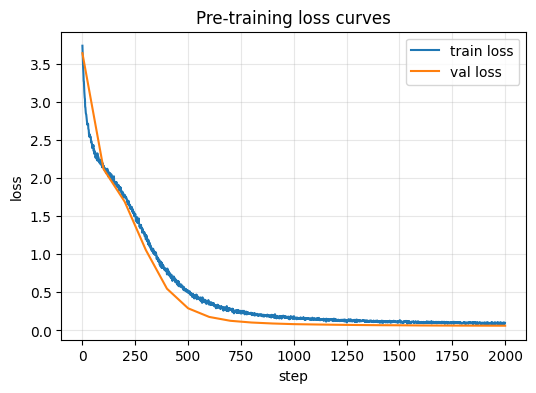


Sample from pre-trained model:
Basketball practice builds muscle memory, confidence, and awareness on the court.
Coaches and players review past games to understand what w


In [7]:

optimizer_pre = torch.optim.AdamW(
    model_pre.parameters(),
    lr=CFG.lr_pretrain,
    weight_decay=CFG.weight_decay,
)

train_losses_pre: List[float] = []
val_losses_pre: List[float] = []

step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for batch in train_loader:
        loss_val = lm_batch_step(model_pre, batch, optimizer_pre)
        train_losses_pre.append(loss_val)
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            val_loss = eval_loss(model_pre, val_loader)
            val_losses_pre.append(val_loss)
            ppl = perplexity(val_loss)
            pbar.set_description(
                f"Pre-training | step {step} | train {loss_val:.3f} | val {val_loss:.3f} | ppl {ppl:.1f}"
            )

        pbar.update(1)
        if step >= CFG.max_steps_pretrain:
            break

pbar.close()

pre_val_loss = val_losses_pre[-1] if val_losses_pre else float("nan")
print(f"Final pre-train val loss: {pre_val_loss:.3f}  (ppl ≈ {perplexity(pre_val_loss):.1f})")

plot_losses(train_losses_pre, val_losses_pre, title="Pre-training loss curves")

print("\nSample from pre-trained model:")
print(sample_text(model_pre, tokenizer, prompt="Basketball practice ", max_new_tokens=120))


SFT train text:
 Instruction: Write a tagline that combines coffee and basketball practice.
Answer: Brew the energy, shoot the shot, own the court.

Instruction: Give a very short motivational line for training.
Answer: Show up today, be stronger tomorrow.

Instruction: Summarize: 'Teams review game footage to improve next time.'
Answer: They watch past games to fix mistakes and plan better plays.

Instruction: Give a fun tagline for a morning workout.
Answer: Wake up, warm up, and win the day.

Instruction: Give a creative tagline for coffee before practice.
Answer: Coffee, then courage – sip, smile, and start your session.

Instruction: Write a one-line tip for staying motivated to train.
Answer: Track your progress and celebrate small wins each week.


SFT val text:
 Instruction: Explain in one sentence what perplexity is.
Answer: Perplexity measures how surprised a language model is by the next token.

Instruction: Write a short motto about learning a new sport.
Answer: Start small

SFT:   0%|          | 0/200 [00:00<?, ?it/s]

Final SFT val loss: 2.535  (ppl ≈ 12.6)


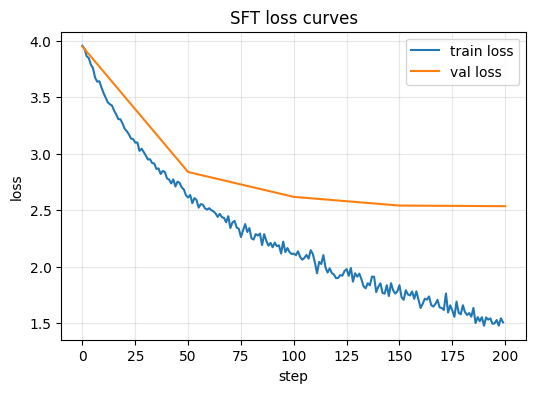


Before SFT (pre-trained only):
Basketball practice builds muscle memory, confidence, and awareness on the court.
Coaches and player

After SFT:
Instruction: Give a creative tagline for coffee before practice.
Answer: Sip ideas. Brew brilliance.


In [8]:
SFT_PAIRS: List[Tuple[str, str]] = [
    ("Write a short motto about learning a new sport.",
     " Start small, stay curious, and keep moving."),
    ("Summarize: 'Teams review game footage to improve next time.'",
     " They watch past games to fix mistakes and plan better plays."),
    ("Give a creative tagline for coffee before practice.",
     " Coffee, then courage – sip, smile, and start your session."),
    ("Explain in one sentence what perplexity is.",
     " Perplexity measures how surprised a language model is by the next token."),
    ("Write a one-line tip for staying motivated to train.",
     " Track your progress and celebrate small wins each week."),
    ("Give a fun tagline for a morning workout.",
     " Wake up, warm up, and win the day."),
    ("Write a tagline that combines coffee and basketball practice.",
     " Brew the energy, shoot the shot, own the court."),
    ("Give a very short motivational line for training.",
     " Show up today, be stronger tomorrow."),
]



def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    blocks = []
    for instruction, answer in pairs:
        blocks.append(f"Instruction: {instruction}\nAnswer:{answer}\n\n")
    return "".join(blocks)

random.shuffle(SFT_PAIRS)
n_val_pairs = max(1, len(SFT_PAIRS) // 4)
sft_val_pairs = SFT_PAIRS[:n_val_pairs]
sft_train_pairs = SFT_PAIRS[n_val_pairs:]

sft_train_text = build_sft_text(sft_train_pairs)
sft_val_text = build_sft_text(sft_val_pairs)

print("SFT train text:\n", sft_train_text)
print("SFT val text:\n", sft_val_text)

# Re-initialize tokenizer and update CFG.vocab_size for SFT
# Combine corpus_text with SFT texts to ensure all characters are in the vocabulary
full_text_for_tokenizer = corpus_text + sft_train_text + sft_val_text
tokenizer_sft = CharTokenizer(full_text_for_tokenizer)
CFG.vocab_size = tokenizer_sft.vocab_size
print(f"Updated Vocab size for SFT: {CFG.vocab_size}")

sft_train_ds = LMDataset(sft_train_text, tokenizer_sft, CFG.context_length)
sft_val_ds = LMDataset(sft_val_text, tokenizer_sft, CFG.context_length)

sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)
len(sft_train_ds), len(sft_val_ds)
# Copy pre-trained model weights
model_sft = TinyGPT(
    vocab_size=CFG.vocab_size,
    d_model=CFG.d_model,
    n_layers=CFG.n_layers,
    n_heads=CFG.n_heads,
    dropout=CFG.dropout,
    context_length=CFG.context_length,
).to(CFG.device)

# Manually load state_dict to handle vocab_size change
pretrained_dict = model_pre.state_dict()
model_sft_dict = model_sft.state_dict()

# Filter out incompatible keys (token_embed and lm_head) due to vocab_size change
# and only load layers with matching shapes
pretrained_dict = {
    k: v for k, v in pretrained_dict.items()
    if k in model_sft_dict and v.size() == model_sft_dict[k].size()
}

# Update model_sft's state dict with compatible pre-trained weights
model_sft_dict.update(pretrained_dict)
# Load the updated state dict into model_sft
model_sft.load_state_dict(model_sft_dict)

optimizer_sft = torch.optim.AdamW(
    model_sft.parameters(),
    lr=CFG.lr_sft,
    weight_decay=CFG.weight_decay,
)

train_losses_sft: List[float] = []
val_losses_sft: List[float] = []

step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for batch in sft_train_loader:
        loss_val = lm_batch_step(model_sft, batch, optimizer_sft)
        train_losses_sft.append(loss_val)
        step += 1

        if step % max(1, CFG.eval_every // 2) == 0 or step == 1:
            val_loss = eval_loss(model_sft, sft_val_loader)
            val_losses_sft.append(val_loss)
            pbar.set_description(
                f"SFT | step {step} | train {loss_val:.3f} | val {val_loss:.3f}"
            )

        pbar.update(1)
        if step >= CFG.max_steps_sft:
            break

pbar.close()

sft_val_loss = val_losses_sft[-1] if val_losses_sft else float("nan")
print(f"Final SFT val loss: {sft_val_loss:.3f}  (ppl \u2248 {perplexity(sft_val_loss):.1f})")

plot_losses(train_losses_sft, val_losses_sft, title="SFT loss curves")

# Original prompt for SFT model
test_prompt_sft = "Instruction: Give a creative tagline for coffee before practice.\nAnswer:"

print("\nBefore SFT (pre-trained only):")
# Create a tokenizer specifically for model_pre's original vocabulary
# This is necessary because the global 'tokenizer' variable was updated for SFT.
tokenizer_pre_for_sampling = CharTokenizer(corpus_text)
# Use a prompt compatible with the pre-trained model's vocabulary
print(sample_text(model_pre, tokenizer_pre_for_sampling, prompt="Basketball practice ", max_new_tokens=80))

print("\nAfter SFT:")
print(sample_text(model_sft, tokenizer_sft, prompt=test_prompt_sft, max_new_tokens=80))


In [9]:

def simple_reward(text: str) -> float:

    t = text.lower()
    words = t.split()
    r = 0.0
    if "coffee" in t:
        r += 1.0
    if "!" in text:
        r += 0.5
    if 8 <= len(words) <= 20:
        r += 0.5
    return r


def rl_rollout(model: nn.Module, prompt: str) -> Tuple[str, torch.Tensor]:

    model.eval()
    device = CFG.device

    # Use tokenizer_sft which has the expanded vocabulary for SFT/RL prompts
    prompt_ids = tokenizer_sft.encode(prompt)
    x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, :]

    logprobs: List[torch.Tensor] = []

    for _ in range(60):  # short rollout
        x_cond = x[:, -CFG.context_length :]
        logits = model(x_cond)
        logits = logits[:, -1, :] / CFG.temperature
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        # Fix: Unsqueeze action to match dimensions of x before concatenation
        action = dist.sample().unsqueeze(1)           # (1, 1)
        logprob = dist.log_prob(action.squeeze(1))  # (1,)

        x = torch.cat([x, action], dim=1)
        logprobs.append(logprob.squeeze(0))  # store (1,) per step

    ids = x[0].tolist()
    text = tokenizer_sft.decode(ids) # Use tokenizer_sft for decoding as well
    total_logprob = torch.stack(logprobs).sum()
    return text, total_logprob


# Initialize RL model from SFT weights
model_rl = TinyGPT(
    vocab_size=CFG.vocab_size,
    d_model=CFG.d_model,
    n_layers=CFG.n_layers,
    n_heads=CFG.n_heads,
    dropout=CFG.dropout,
    context_length=CFG.context_length,
).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())

optimizer_rl = torch.optim.AdamW(
    model_rl.parameters(),
    lr=CFG.lr_rl,
    weight_decay=CFG.weight_decay,
)

rl_rewards: List[float] = []

rl_prompt = "Instruction: Give a creative tagline for coffee before practice.\nAnswer:"

for step in tqdm(range(CFG.max_steps_rl), desc="RL fine-tuning"):
    gen_text, logprob_sum = rl_rollout(model_rl, rl_prompt)
    # Only score the answer part to avoid rewarding the fixed prompt
    answer_part = gen_text.split("Answer:", 1)[-1]

    r = simple_reward(answer_part)
    rl_rewards.append(r)

    loss = -logprob_sum * r  # REINFORCE objective
    optimizer_rl.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model_rl.parameters(), CFG.grad_clip)
    optimizer_rl.step()

print("Average reward during RL:", np.mean(rl_rewards))

print("\nAfter RL fine-tuning:")
print(sample_text(model_rl, tokenizer_sft, prompt=rl_prompt, max_new_tokens=80))

RL fine-tuning:   0%|          | 0/150 [00:00<?, ?it/s]

Average reward during RL: 0.5066666666666667

After RL fine-tuning:
Instruction: Give a creative tagline for coffee before practice.
Answer: Cool down, sip up – coffee that rewards every rep.
